In [1]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.stats import uniform

import random
import math

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Load data

In [2]:
city_df = pd.read_csv("./city/city.csv")

In [3]:
city_df.head(3)

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830


In [4]:
city_df.geo_lat.describe(),city_df.geo_lon.describe()

(count    1117.000000
 mean       54.553128
 std         5.226441
 min        42.058966
 25%        52.144962
 50%        55.150801
 75%        57.145108
 max        69.701666
 Name: geo_lat, dtype: float64,
 count    1117.000000
 mean       54.812533
 std        27.874038
 min        19.914057
 25%        37.861855
 50%        43.919154
 75%        60.107757
 max       177.501542
 Name: geo_lon, dtype: float64)

In [5]:
cord_list = []
for item in pd.read_json("russia.json")['geojson'][0]['coordinates']:
    for cord in item[0]:
        cord_list.append(cord)

cord_list = np.array(cord_list)

## Implementation

### City

In [6]:
def coordinates_transform(lat1,lon1,lat2,lon2):
    #ref: https://www.movable-type.co.uk/scripts/latlong.html
    
    R = 6371
    φ1 = lat1*math.pi/180
    φ2 = lat2*math.pi/180
    Δφ = (lat2 - lat1)*math.pi/180
    Δλ = (lon2 - lon1)*math.pi/180
    
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + \
        math.cos(φ1) * math.cos(φ2)*\
        math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2*math.atan2(a**0.5, (1-a)**0.5 )
    return R*c

In [7]:
class City():
    def __init__(self,name, lat,lon):
        self.name = name
        self.lat = lat
        self.lon = lon
        
    def distance_to(self,city):
        return coordinates_transform(self.lat,self.lon,city.lat,city.lon)
    
    def plot_city(self,ax):
        ax.scatter(x = self.lon, y = self.lat)
        ax.annotate(self.name, (self.lon, self.lat),c='r')
    
    def plot_path(self,ax,city):
        ax.plot([self.lon,city.lon], [self.lat,city.lat],c='b')

### Path

In [8]:
def load_cities():
    cities_path = []
    
    file_path = "./city/city.csv"
    city_df = pd.read_csv(file_path)
    
    names = list(city_df.sort_values('population',ascending=False).address[:30])
    lat_list = list(city_df.sort_values('population',ascending=False).geo_lat[:30])
    lon_list = list(city_df.sort_values('population',ascending=False).geo_lon[:30])
    
    for name,lat,lon in  zip(names,lat_list,lon_list):
        c = City(name,lat,lon)
        cities_path.append(c)
    random.shuffle(cities_path)
    return cities_path

In [9]:
#Test
cities_path = load_cities()
print(cities_path[0].name,cities_path[1].name)
cities_path[0].distance_to(cities_path[1])

Самарская обл, г Тольятти г Ярославль


749.8969986754483

In [10]:
def get_positions(size):
    res = []
    for i in range(2):
        idx1,idx2 = 0,0
        while idx1 == idx2:
            v = [norm.rvs(loc = 0.5,scale=0.16,size = 1),
                 norm.rvs(loc = 0.5,scale=0.16,size = 1)]
            v[0] = max(v[0],0)
            v[0] = v[0] if v[0]<1 else 1

            v[1] = max(v[1],0)
            v[1] = v[1] if v[1]<1 else 1

            idx1 = int(v[0]*size)
            idx2 = int(v[1]*size)
        res.append(idx1)
        res.append(idx2)
    return res[0], res[1], res[2], res[3]

In [11]:
get_positions(30)

(17, 9, 20, 21)

In [12]:
class SalesmanPath():
            
    def __init__(self,visited = [],size = 30):
        if len(visited)>0:
            self.visited = visited
        else:
            print("from load")
            self.visited = self.load_cities(size)
    
    def load_cities(self,size):
        cities_path = []

        file_path = "./city/city.csv"
        city_df = pd.read_csv(file_path)

        names = list(city_df.sort_values('population',ascending=False).address[:size])
        lat_list = list(city_df.sort_values('population',ascending=False).geo_lat[:size])
        lon_list = list(city_df.sort_values('population',ascending=False).geo_lon[:size])

        for name,lat,lon in  zip(names,lat_list,lon_list):
            c = City(name,lat,lon)
            cities_path.append(c)
        random.shuffle(cities_path)
        return cities_path
    
    def get_new_path(self):
        pos1,pos2,pos3,pos4 = get_positions(len(self.visited)-1)
        
        new_visited = self._swap_cities(pos1,pos2,self.visited)
        new_visited = self._swap_cities(pos3,pos4,new_visited)
        new_visited = new_visited.copy()
        return SalesmanPath(new_visited,len(new_visited))

    def _swap_cities(self,pos1,pos2,new_visited):
        
        new_visited[pos1], new_visited[pos2] = new_visited[pos2], new_visited[pos1]
        return new_visited
    
    def get_distance(self):
        total_dist = 0
        for i in range(len(self.visited)):
            next_i = (i + 1) % len(self.visited)
            
            total_dist += self.visited[i].distance_to(self.visited[next_i])
        
        return total_dist
    
    def get_cities_data(self):
        x,y = [],[]
        names = []
        for c in self.visited:
            x.append(c.lon)
            y.append(c.lat)
            names.append(c.name)
        return x,y,names

In [13]:
#Test

In [14]:
def list_cities(visited):
    for v in visited:
        print(v.name)

In [15]:
s_path1 = SalesmanPath(size = 10)
list_cities(s_path1.visited)
print(s_path1.get_distance())
print("------")

s_path2 = s_path1.get_new_path()
list_cities(s_path2.visited)
print(s_path2.get_distance())
s_path1 = s_path2

from load
г Нижний Новгород
г Санкт-Петербург
г Ростов-на-Дону
г Екатеринбург
г Москва
г Казань
г Самара
г Челябинск
г Новосибирск
г Омск
11212.828773202202
------
г Нижний Новгород
г Санкт-Петербург
г Екатеринбург
г Ростов-на-Дону
г Казань
г Москва
г Самара
г Челябинск
г Новосибирск
г Омск
11747.080942841598


### SA algorithm

In [16]:
class StatCollector():
    def __init__(self):
        self.dist = []
        self.best_dist = []
        self.iteration = []
        self.temp = []
        
        self.current_path_hist = []
        self.best_path_hist = []
        self.only_best_path_hist = []
    
    def add(self,d,best_d,t):
        self.best_dist.append(best_d)
        self.dist.append(d)
        self.temp.append(t)
        
        self.iteration.append(len(self.iteration))
    
    def add_hist(self,c_h,b_h):
        self.current_path_hist.append(SalesmanPath(visited = c_h.visited.copy()))
        self.best_path_hist.append(SalesmanPath(visited = b_h.visited.copy()))
    
    def add_best(self,b_h):
        self.only_best_path_hist.append(b_h)

In [17]:
class SA_algorithm():
    def __init__(self,temp, t_decay):
        self.temp = temp
        self.temp_decay = t_decay
        
        self.current_path = SalesmanPath(size = 30) 
        self.best_path = self.current_path
        self.best_energy = self.current_path.get_distance()
        
        self.stat = StatCollector()
        self.stat.add_best(self.best_path)
        
    def acceptance_ration(self,e_current,e_new,temp):
        if (e_new < e_current):
            return 1.0
        else:
            return np.exp((e_current - e_new) / temp);
    
    
    def run(self):
        dist = self.best_energy
        while self.temp>1:    
            
            new_path = self.current_path.get_new_path()
            
            current_energy = self.current_path.get_distance()
            new_energy = new_path.get_distance()
            
            ratio = self.acceptance_ration(current_energy,new_energy,self.temp)
            u = uniform.rvs() #Todo: Position generator distribution
            if ratio > u:
                self.current_path = new_path
                dist = new_energy
            else:
                dist = current_energy
            
            current_energy = self.current_path.get_distance()
            if current_energy < self.best_energy:
                self.best_path = self.current_path
                self.best_energy = current_energy
                
                self.stat.add_best(self.best_path)
                
            
            self.stat.add(d=dist, best_d = self.best_energy,t = self.temp)
            self.temp *= self.temp_decay
            
            self.stat.add_hist(self.current_path,self.best_path)


## Report

### Speed of convergence for three different values

In [18]:
stats_list = []
params = []

In [19]:
t = 10000
t_d = 0.997

alg = SA_algorithm(temp = t, t_decay = t_d)
alg.run()

stats_list.append(alg.stat)
params.append([t,t_d])

from load


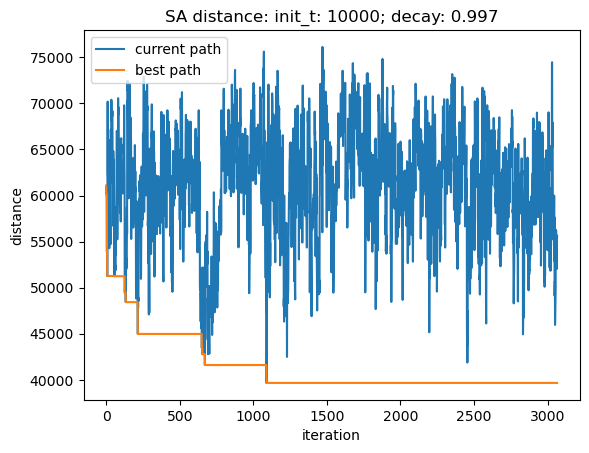

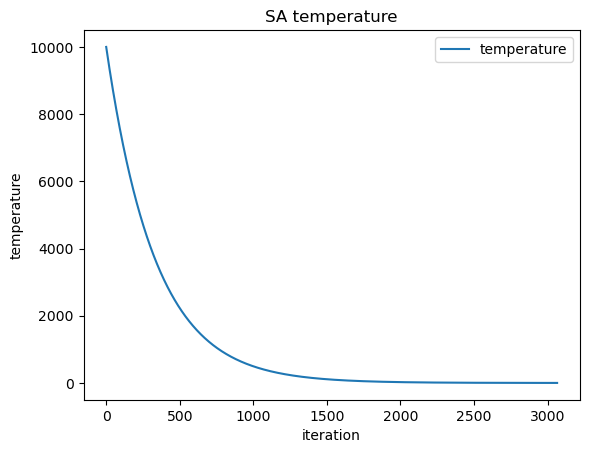

In [20]:
plt.plot(alg.stat.iteration,alg.stat.dist,label = "current path")
plt.plot(alg.stat.iteration,alg.stat.best_dist,label = "best path")
plt.legend()
plt.title(f"SA distance: init_t: {t}; decay: {t_d}")
plt.xlabel("iteration")
plt.ylabel("distance")
plt.show()

plt.plot(alg.stat.iteration,alg.stat.temp,label = "temperature")
plt.legend()
plt.title(f"SA temperature")
plt.xlabel("iteration")
plt.ylabel("temperature")
plt.show()

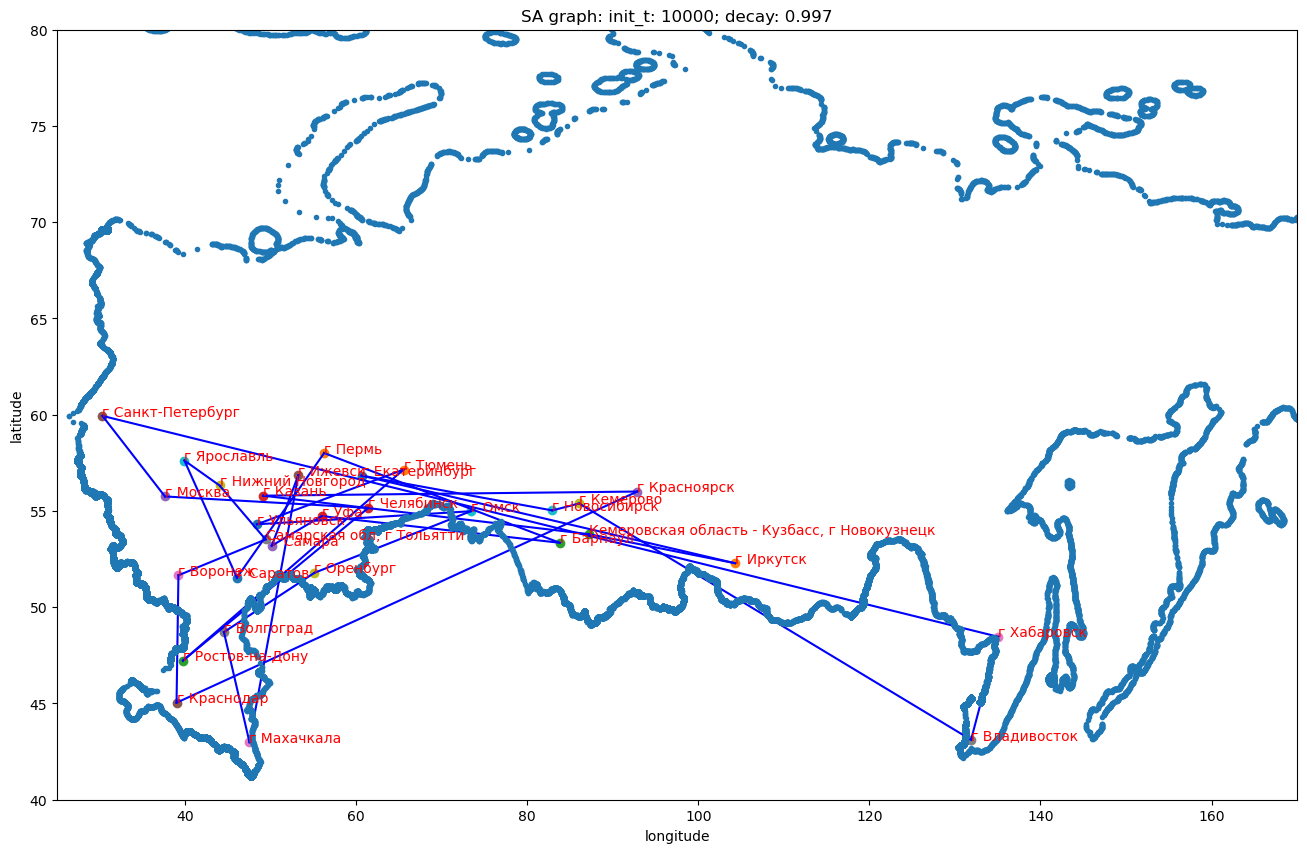

In [21]:
fig, ax = plt.subplots(figsize=(16, 10))
n_cities = len(alg.best_path.visited)
for i in range(n_cities):
    c = alg.best_path.visited[i]
    c_next = alg.best_path.visited[(i+1)%n_cities]
    c.plot_city(ax)
    c.plot_path(ax,c_next)

plt.plot(cord_list[:,0],cord_list[:,1],'.')
plt.title(f"SA graph: init_t: {t}; decay: {t_d}")

plt.xlim(25, 170)
plt.ylim(40, 80)

plt.xlabel("longitude")
plt.ylabel("latitude")

plt.show()

In [22]:
t = 10000
t_d = 0.99

alg = SA_algorithm(temp = t, t_decay = t_d)
alg.run()

stats_list.append(alg.stat)
params.append([t,t_d])

from load


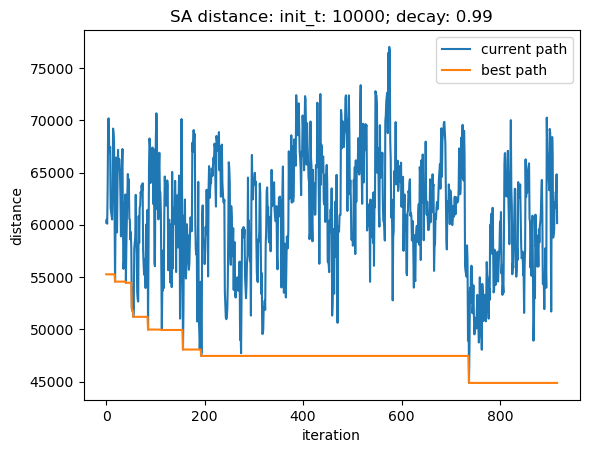

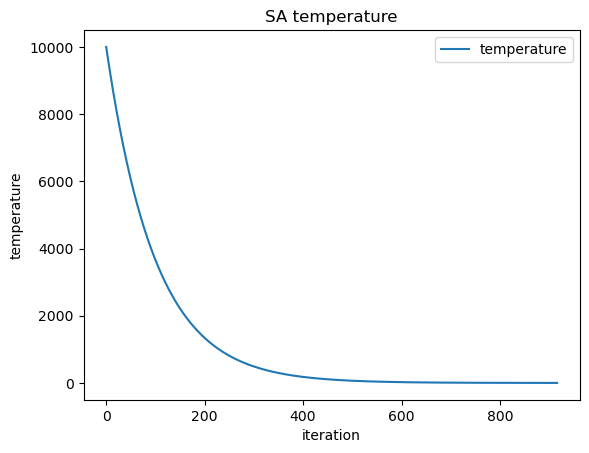

In [23]:
plt.plot(alg.stat.iteration,alg.stat.dist,label = "current path")
plt.plot(alg.stat.iteration,alg.stat.best_dist,label = "best path")
plt.legend()
plt.title(f"SA distance: init_t: {t}; decay: {t_d}")
plt.xlabel("iteration")
plt.ylabel("distance")
plt.show()

plt.plot(alg.stat.iteration,alg.stat.temp,label = "temperature")
plt.legend()
plt.title(f"SA temperature")
plt.xlabel("iteration")
plt.ylabel("temperature")
plt.show()

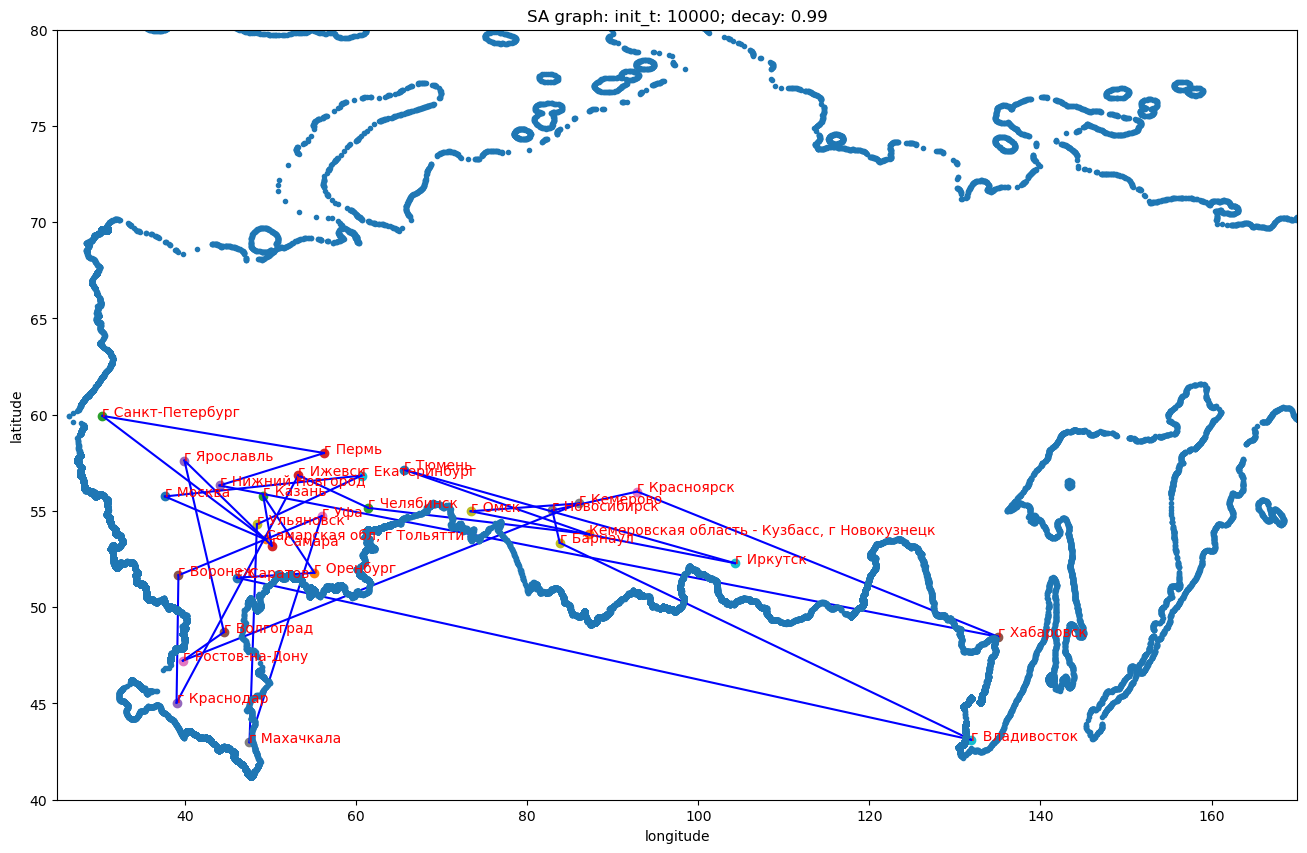

In [24]:
fig, ax = plt.subplots(figsize=(16, 10))
n_cities = len(alg.best_path.visited)
for i in range(n_cities):
    c = alg.best_path.visited[i]
    c_next = alg.best_path.visited[(i+1)%n_cities]
    c.plot_city(ax)
    c.plot_path(ax,c_next)

plt.xlim(25, 170)
plt.ylim(40, 80)

plt.plot(cord_list[:,0],cord_list[:,1],'.')
plt.title(f"SA graph: init_t: {t}; decay: {t_d}")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.show()

In [25]:
t = 10000
t_d = 0.75

alg = SA_algorithm(temp = t, t_decay = t_d)
alg.run()

stats_list.append(alg.stat)
params.append([t,t_d])

from load


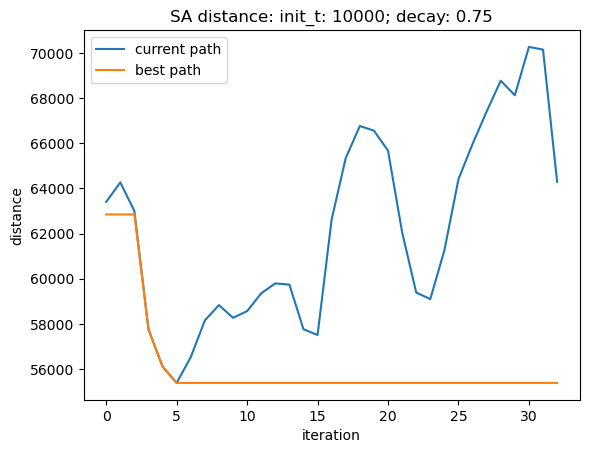

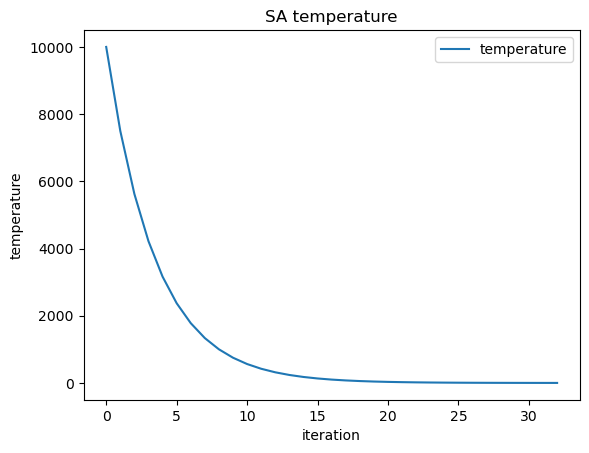

In [26]:
plt.plot(alg.stat.iteration,alg.stat.dist,label = "current path")
plt.plot(alg.stat.iteration,alg.stat.best_dist,label = "best path")
plt.legend()
plt.title(f"SA distance: init_t: {t}; decay: {t_d}")
plt.xlabel("iteration")
plt.ylabel("distance")
plt.show()

plt.plot(alg.stat.iteration,alg.stat.temp,label = "temperature")
plt.legend()
plt.title(f"SA temperature")
plt.xlabel("iteration")
plt.ylabel("temperature")
plt.show()

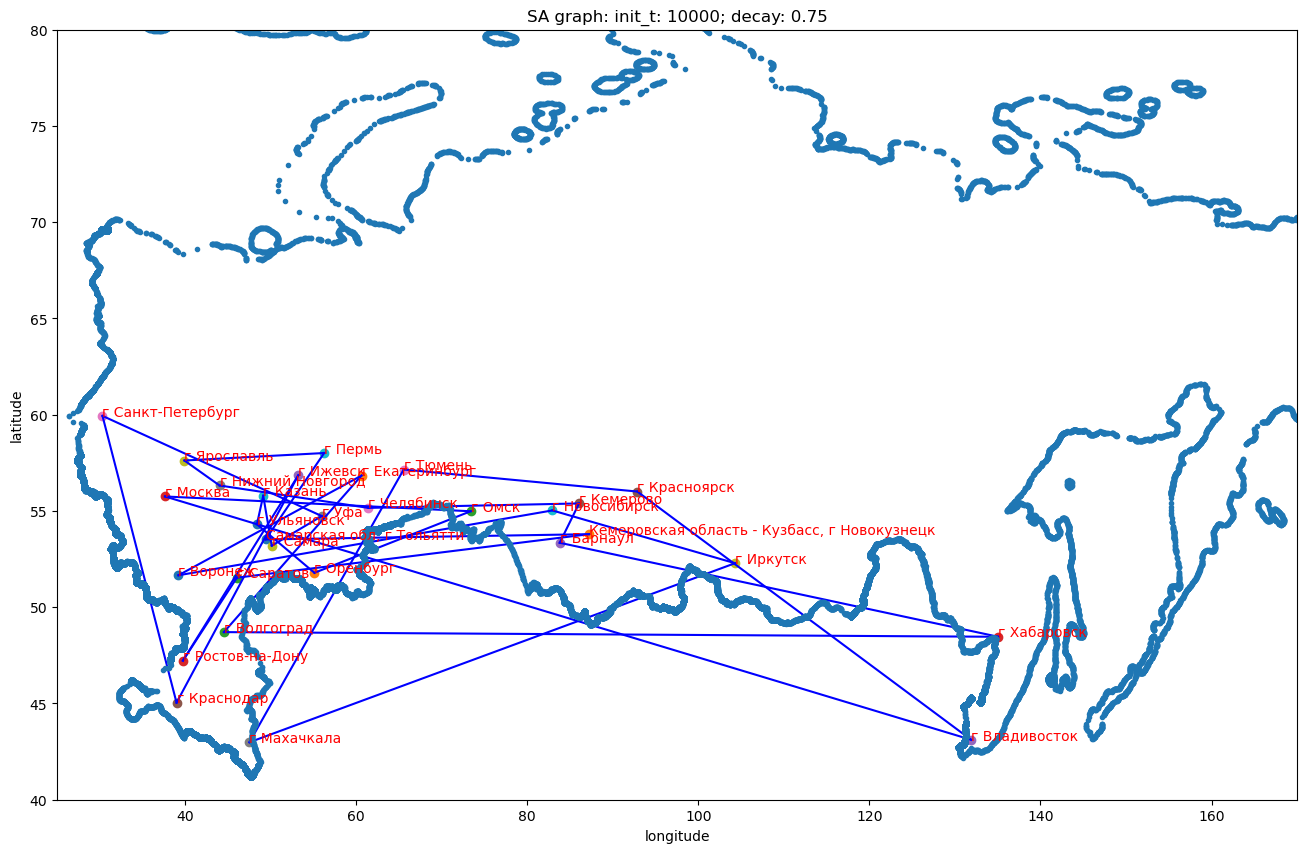

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))
n_cities = len(alg.best_path.visited)
for i in range(n_cities):
    c = alg.best_path.visited[i]
    c_next = alg.best_path.visited[(i+1)%n_cities]
    c.plot_city(ax)
    c.plot_path(ax,c_next)

plt.xlim(25, 170)
plt.ylim(40, 80)
    
plt.plot(cord_list[:,0],cord_list[:,1],'.')
plt.title(f"SA graph: init_t: {t}; decay: {t_d}")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.show()

#### Summary plot

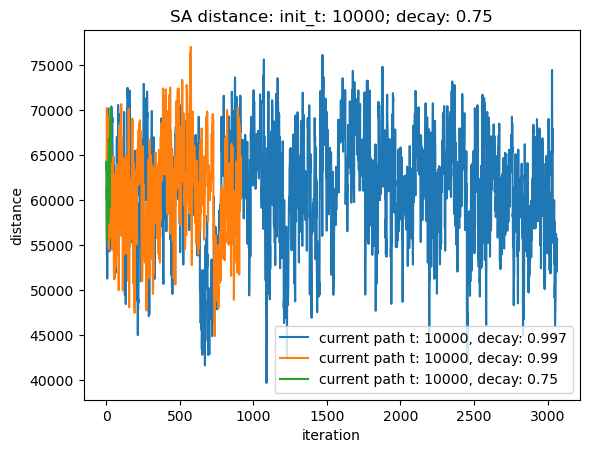

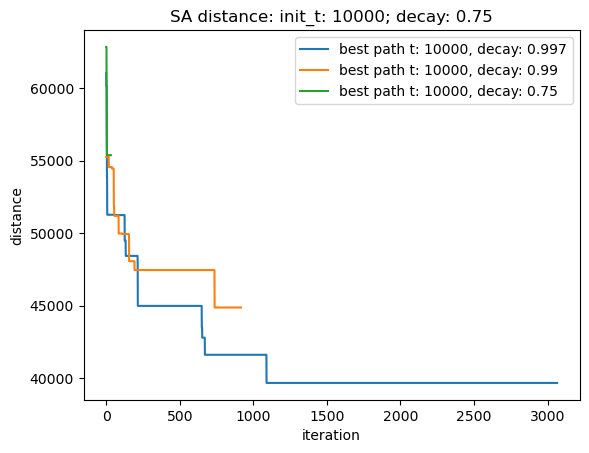

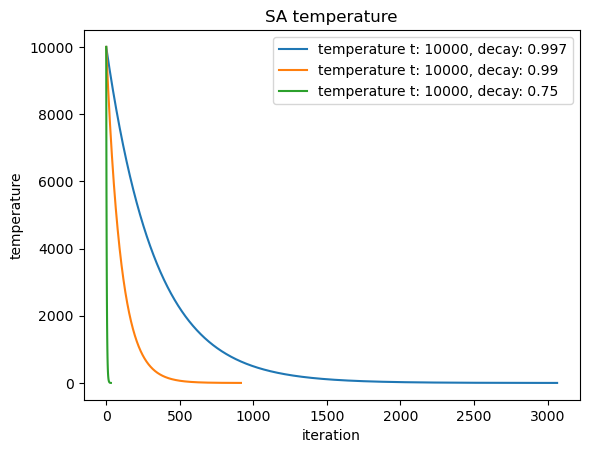

In [28]:

for p,stat in zip(params,stats_list):
    plt.plot(stat.iteration,stat.dist,label = f"current path t: {p[0]}, decay: {p[1]}")
    plt.legend()
    plt.title(f"SA distance: init_t: {t}; decay: {t_d}")
    plt.xlabel("iteration")
    plt.ylabel("distance")
plt.show()

for p,stat in zip(params,stats_list):
    plt.plot(stat.iteration,stat.best_dist,label = f"best path t: {p[0]}, decay: {p[1]}")
    plt.legend()
    plt.title(f"SA distance: init_t: {t}; decay: {t_d}")
    plt.xlabel("iteration")
    plt.ylabel("distance")
plt.show()
    
for p,stat in zip(params,stats_list):
    plt.plot(stat.iteration,stat.temp,label = f"temperature t: {p[0]}, decay: {p[1]}")
    plt.legend()
    plt.title(f"SA temperature")
    plt.xlabel("iteration")
    plt.ylabel("temperature")
plt.show()

### Plots

In [29]:
t = 10000
t_d = 0.997

alg = SA_algorithm(temp = t, t_decay = t_d)
alg.run()


from load


In [30]:
def list_cities(visited):
    for v in visited:
        print(v.name)

In [31]:
#alg.stat.best_path_hist
len(alg.stat.only_best_path_hist)
len(alg.stat.current_path_hist)

3066

In [39]:
# def plot_current(ax,path):
#     #fig, ax = plt.subplots(figsize=(20, 12))
#     n_cities = len(path.visited)
#     for i in range(n_cities):
#         c = path.visited[i]
#         c_next = path.visited[(i+1)%n_cities]
#         c.plot_city(ax)
#         c.plot_path(ax,c_next)
def record(algs_list,freq):
    
    fig, ax = plt.subplots(figsize=(16, 10))
    #xdata, ydata = [], []
    ln, = ax.plot([], [])

    def init():
        ax.set_xlim(25, 170)
        ax.set_ylim(40, 80)
        return ln,

    def update(frame):
        #xdata.append(frame)
        #ydata.append(np.sin(frame))
        #ln.set_data(xdata, ydata)
        cities = algs_list[frame].visited
        x,y,names = [],[],[]
        for c in cities:
            x.append(c.lon)
            y.append(c.lat)
            names.append(c.name)
            
        #x,y,names = algs_list[frame].get_cities_data()
        
        #plot_current(ax,)
        #print(x,y)
        ln.set_data(x,y)
        
        for l,la,n in zip(x,y,names):
            ax.annotate(text = n, xy = (l, la),c='r')
        
        
        ax.plot(cord_list[:,0],cord_list[:,1],'.',c = 'g')
        ax.set_title(f"Iteration: {frame}")
        return ln,

    ani = FuncAnimation(fig, update, frames=np.arange(0,len(algs_list),freq),
                        init_func=init, blit=True)
    ani.save(filename = f"sample_{freq}.mp4")
    plt.show()

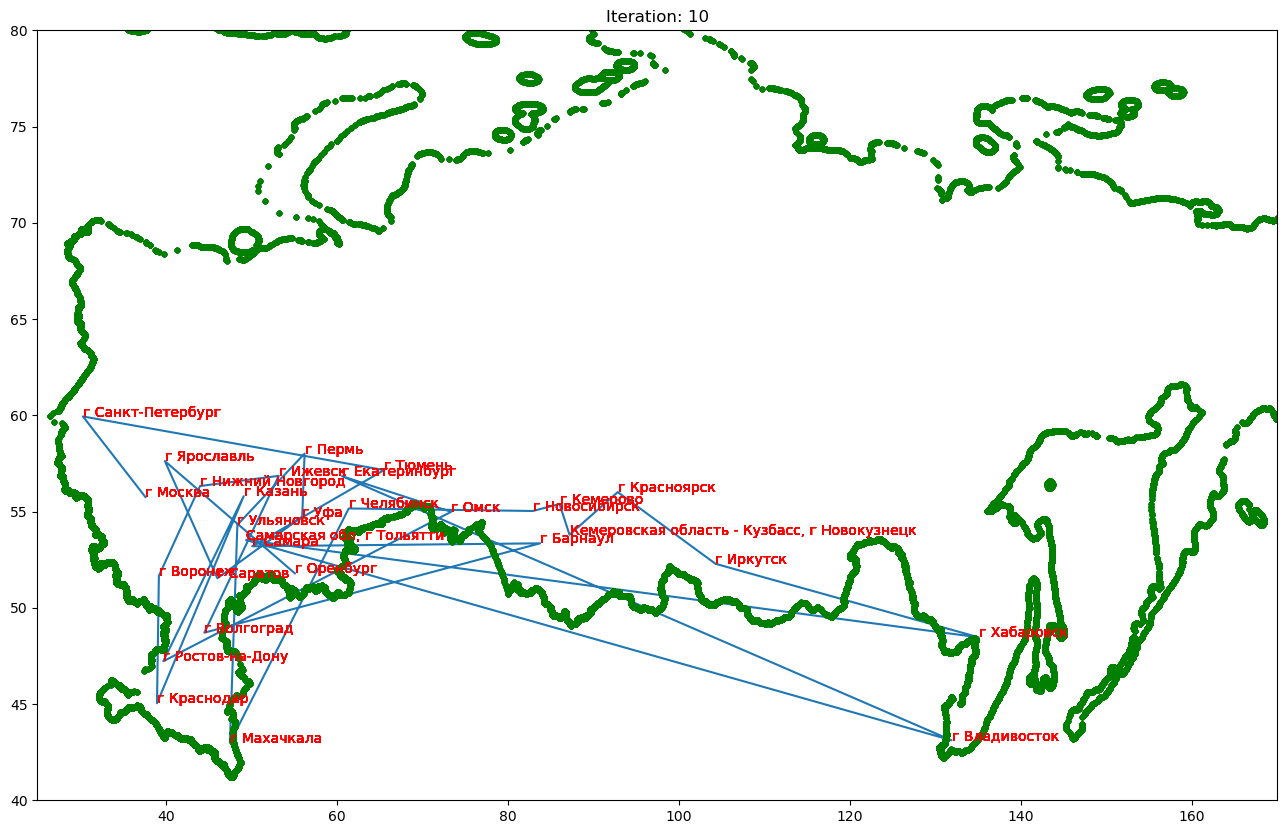

In [40]:
record(alg.stat.only_best_path_hist,1)

In [ ]:
# record(alg.stat.current_path_hist,1000)
# record(alg.stat.current_path_hist,100)
record(alg.stat.current_path_hist,1)

In [ ]:
# record(alg.stat.best_path_hist,100)
#record(alg.stat.best_path_hist,1)

In [36]:
# def list_cities(visited):
#     for v in visited:
#         print(v.name)